# Otimização Combinatória

Programação Linear - Otimização na Fabricação de Biscoitos

In [1]:
import gurobipy as gp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Instância do Modelo e Parâmetros do Problema - Gurobi Solver

In [2]:
md = gp.Model('Otimização do estoque de biscoitos')

tps_biscoitos = 5
qtd_periodos = 12

#Demanda por Período x Produto
mat_demandas = [[130,70,25,40,60],[128,65,10,30,50],[120,120,20,20,50,50],
                [135,72,12,35,40],[138,70,32,20,50],[80,70,12,20,25],
                [130,66,15,25,30],[135,67,20,30,20],[130,70,22,32,42],
                [136,92,40,43,64],[112,120,60,72,90],[186,173,55,82,95]]

#Matrizes produto x tempo
biscoitos = [f'Biscoito {b+1}' for b in range(tps_biscoitos)]
periodos  = [t+1 for t in range(qtd_periodos)]

print('biscoito: ',biscoitos)
print('periodo : ',periodos)

# Recursos disponíveis por período
vet_recursos_disp = [260, 160, 0, 200, 180, 180, 260, 240, 260, 260, 260, 260]

# Dicionários com os recursos disponíveis por período
recursos_disp = dict()
for t, periodo in enumerate(periodos):
    recursos_disp[periodo] = vet_recursos_disp[t]

# Dicionário com as Demandas
demandas = dict()
for t, periodo in enumerate(periodos):
    for j, biscoito in enumerate(biscoitos):
        demandas[periodo, biscoito] = mat_demandas[t][j]

# Parâmetros dos produtos
vet_est_ini = [30, 50,10,20,10]
vet_est_final = [250,180,120,120,80]
vet_custo_estoque = [2.0, 3.5,1.2,1.75,1.0]
vet_recursos_biscoito = [0.2, 0.4,0.15,0.12,0.11]

#M-Grande (Valor Base para ajuste do Setup)
m_grande = sum(vet_est_final)
for t in mat_demandas:
    m_grande+= sum(t)
print('M-Grande: ',m_grande)

# Dicionário com os parâmetros dos produtos
estoque_inicial = dict()
estoque_final = dict()
custo_estoque = dict()
recursos_biscoito = dict()

for j, biscoito in enumerate(biscoitos):
    estoque_inicial[biscoito] = vet_est_ini[j]
    estoque_final[biscoito] = vet_est_final[j]
    custo_estoque[biscoito] = vet_custo_estoque[j]
    recursos_biscoito[biscoito] = vet_recursos_biscoito[j]

Restricted license - for non-production use only - expires 2022-01-13
biscoito:  ['Biscoito 1', 'Biscoito 2', 'Biscoito 3', 'Biscoito 4', 'Biscoito 5']
periodo :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
M-Grande:  4803


Variáveis de Decisão

In [3]:
producao = md.addVars(periodos, biscoitos, vtype = gp.GRB.INTEGER)
estoque  = md.addVars(periodos, biscoitos, vtype = gp.GRB.INTEGER)

Função Objetivo

In [4]:
md.setObjective(
    gp.quicksum(estoque[t, j] * custo_estoque[j]
                for t in periodos for j in biscoitos),
    sense=gp.GRB.MINIMIZE)

Restrições

In [5]:
# Restrição do Estoque Inicial
c_est_t0 = md.addConstrs(
    producao[1, j] + estoque_inicial[j] - demandas[1, j] == estoque[1, j]
    for j in biscoitos)

# Restrição para ajuste e atualização do estoque
c_estoque = md.addConstrs(
    producao[t, j] + estoque[t - 1, j] - demandas[t, j] == estoque[t, j]
    for t in periodos[1:] for j in biscoitos)

# Restrição que garante o estoque final para ano subsequente
periodo_final = periodos[-1]
c_est_final = md.addConstrs(
    estoque[periodo_final, j] == estoque_final[j]
    for j in biscoitos)

# Restrição dos recursos por período
c_recursos = md.addConstrs(
    gp.quicksum(recursos_biscoito[j] * producao[t, j] for j in biscoitos) <= recursos_disp[t]
    for t in periodos)

# Restrição das demandas por período
c_demanda = md.addConstrs(
    producao[t, j] + estoque[t - 1, j] >= demandas[t, j] 
    for t in periodos[1:] for j in biscoitos)

# Restrição da capacidade total
c_capacidade = md.addConstrs(
    producao[t, j] <= vet_recursos_disp[t-1]
    for t in periodos for j in biscoitos)

Otimização do Modelo

In [6]:
md.optimize()

print("----------------------------------------")
print(f"--- Custo de estoque ótimo: {md.objVal:,.2f} ---")
print("----------------------------------------\n")

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 192 rows, 120 columns and 410 nonzeros
Model fingerprint: 0x25b2f5a0
Variable types: 0 continuous, 120 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Found heuristic solution: objective 7900.9500000
Presolve removed 183 rows and 107 columns
Presolve time: 0.01s
Presolved: 9 rows, 13 columns, 29 nonzeros
Found heuristic solution: objective 3744.0000000
Variable types: 0 continuous, 13 integer (0 binary)

Root relaxation: objective 3.330000e+03, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    3330.0000000 3330.00000  0.00%     -    0s

Explored 0 n

Plano de Produção para Minimização de Custo de Estoque

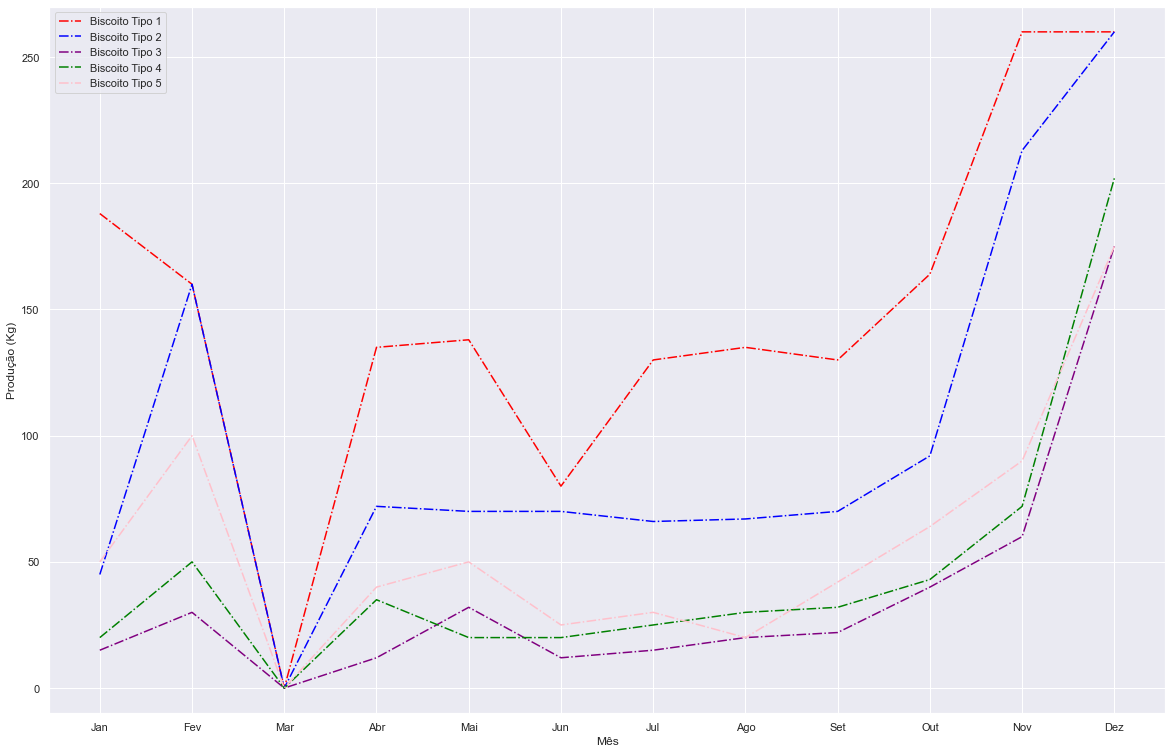

In [7]:
#Gráfico Para produção ótima
b = []
for j in biscoitos:
    for t in periodos:
        b.append(producao[t, j].X)

#Eixos 
y = [b[0:12],b[12:24],b[24:36],b[36:48],b[48:60]]
x  = ['Jan','Fev','Mar','Abr','Mai','Jun'
      ,'Jul','Ago','Set','Out','Nov','Dez']

sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(20,13))

sns.lineplot(x=x, y=y[0], linestyle="dashdot",color="red",    label='Biscoito Tipo 1')
sns.lineplot(x=x, y=y[1], linestyle="dashdot",color="blue",   label='Biscoito Tipo 2')
sns.lineplot(x=x, y=y[2], linestyle="dashdot",color="purple", label='Biscoito Tipo 3')
sns.lineplot(x=x, y=y[3], linestyle="dashdot",color="green",  label='Biscoito Tipo 4')
sns.lineplot(x=x, y=y[4], linestyle="dashdot",color="pink",   label='Biscoito Tipo 5')
plt.ylim(-10,270)


plt.xlabel('Mês')
plt.ylabel('Produção (Kg)')

plt.show()

fig.tight_layout()

In [8]:
#Impressão do Plano de Produção

print("---------------------------------------")
print("--- PLANO DE PRODUÇÃO DOS BISCOITOS ---")
print("---------------------------------------")
for t in periodos:
    print("+++++++++++")
    print("Período:", t)
    print("+++++++++++")
    for j in biscoitos:
        qtd = round(producao[t, j].X)
        print("Produzir {} unidades do {}".format(qtd, j))
        print('Estoque: ',estoque[t, j].X)
        print("****************")
    print("---------------------------------------")

---------------------------------------
--- PLANO DE PRODUÇÃO DOS BISCOITOS ---
---------------------------------------
+++++++++++
Período: 1
+++++++++++
Produzir 188 unidades do Biscoito 1
Estoque:  88.0
****************
Produzir 45 unidades do Biscoito 2
Estoque:  25.0
****************
Produzir 15 unidades do Biscoito 3
Estoque:  -0.0
****************
Produzir 20 unidades do Biscoito 4
Estoque:  -0.0
****************
Produzir 50 unidades do Biscoito 5
Estoque:  -0.0
****************
---------------------------------------
+++++++++++
Período: 2
+++++++++++
Produzir 160 unidades do Biscoito 1
Estoque:  120.0
****************
Produzir 160 unidades do Biscoito 2
Estoque:  120.0
****************
Produzir 30 unidades do Biscoito 3
Estoque:  20.0
****************
Produzir 50 unidades do Biscoito 4
Estoque:  20.0
****************
Produzir 100 unidades do Biscoito 5
Estoque:  50.0
****************
---------------------------------------
+++++++++++
Período: 3
+++++++++++
Produzir 0 unidades